#### This notebook was inspired from [here](https://www.kaggle.com/code/ammarnassanalhajali/layout-parser-model-training)

# Detectron2

[Detectron2](https://detectron2.readthedocs.io/en/latest/index.html) is a popular open-source software library developed by Facebook AI Research (FAIR) for building computer vision models. It serves as a powerful framework for object detection, instance segmentation, and keypoint detection tasks. Detectron2 is built on top of PyTorch, geared towards a more convenient way to build modular, flexible pipelines for specific Computer Vision Tasks such as object detection, instance segmentation. 

Detectron2 has a collection of trained models for these tasks in their [model zoo](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md). We can also use detectron2 to train pre-implemented state-of-the-art models from scratch for new datasets, as we do in this notebook. 

Read the [documentation](https://detectron2.readthedocs.io/en/latest/index.html). 

# 1 Install detectron2

## 1.1 Recommended Way (is not working on kaggle)

## 1.2 Fast Way
Ignore the warnings.

In [1]:
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15149, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 15149 (delta 89), reused 115 (delta 59), pack-reused 14979
Receiving objects: 100% (15149/15149), 6.20 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (10956/10956), done.
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.9 MB/s eta 0:00:00
  Preparing met

# 2 Notebook Config

## 2.1 Decisions

In [2]:
from datetime import datetime

# if False, model is set to `PRETRAINED_PATH` model
is_train = True

# if True, evaluate on validation dataset
is_evaluate = False

# if True, run inference on test dataset
is_inference = True

# if True and `is_train` == True, `PRETRAINED_PATH` model is trained further
is_resume_training = False

# Perform augmentation
is_augment = False

SEED = int(datetime.now().timestamp())

## 2.2 Paths

In [3]:
from pathlib import Path

TRAIN_IMG_DIR = Path("/kaggle/input/dlsprint2/badlad/images/train")

TRAIN_COCO_PATH = Path("/kaggle/input/dlsprint2/badlad/labels/coco_format/train/badlad-train-coco.json")

TEST_IMG_DIR = Path("/kaggle/input/dlsprint2/badlad/images/test")

TEST_METADATA_PATH = Path("/kaggle/input/dlsprint2/badlad/badlad-test-metadata.json")

# Training output directory
OUTPUT_DIR = Path("./output")
OUTPUT_MODEL = OUTPUT_DIR/"model_final.pth"

# Path to your pretrained model weights
PRETRAINED_PATH = Path("")

In [4]:
# Model path based on Decisions
MODEL_PATH = OUTPUT_MODEL if is_train else PRETRAINED_PATH

## 2.3 imports

In [5]:
# detectron2
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.utils.logger import setup_logger
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm  # progress bar
import matplotlib.pyplot as plt
import json
import cv2
import copy
from typing import Optional

from IPython.display import FileLink

# torch
import torch

import gc

import warnings
# Ignore "future" warnings and Data-Frame-Slicing warnings.
warnings.filterwarnings('ignore')

setup_logger()

<_Logger detectron2 (DEBUG)>

# 3 COCO Annotations Data

## 3.1 Load

In [6]:
with TRAIN_COCO_PATH.open() as f:
    train_dict = json.load(f)

with TEST_METADATA_PATH.open() as f:
    test_dict = json.load(f)

print("#### LABELS AND METADATA LOADED ####")

#### LABELS AND METADATA LOADED ####


## 3.2 Observe

In [7]:
def organize_coco_data(data_dict: dict) -> tuple[list[str], list[dict], list[dict]]:
    thing_classes: list[str] = []

    # Map Category Names to IDs
    for cat in data_dict['categories']:
        thing_classes.append(cat['name'])

    # Images
    images_metadata: list[dict] = data_dict['images']

    # Convert COCO annotations to detectron2 annotations format
    data_annotations = []
    for ann in data_dict['annotations']:
        # coco format -> detectron2 format
        annot_obj = {
            # Annotation ID
            "id": ann['id'],

            # Segmentation Polygon (x, y) coords
            "gt_masks": ann['segmentation'],

            # Image ID for this annotation (Which image does this annotation belong to?)
            "image_id": ann['image_id'],

            # Category Label (0: paragraph, 1: text box, 2: image, 3: table)
            "category_id": ann['category_id'],

            "x_min": ann['bbox'][0],  # left
            "y_min": ann['bbox'][1],  # top
            "x_max": ann['bbox'][0] + ann['bbox'][2],  # left+width
            "y_max": ann['bbox'][1] + ann['bbox'][3]  # top+height
        }
        data_annotations.append(annot_obj)

    return thing_classes, images_metadata, data_annotations

In [8]:
thing_classes, images_metadata, data_annotations = organize_coco_data(
    train_dict
)

thing_classes_test, images_metadata_test, _ = organize_coco_data(
    test_dict
)

These are the categories we are going to detect.

In [9]:
print(thing_classes)

['paragraph', 'text_box', 'image', 'table']


In [10]:
train_metadata = pd.DataFrame(images_metadata)
train_metadata = train_metadata[['id', 'file_name', 'width', 'height']]
train_metadata = train_metadata.rename(columns={"id": "image_id"})
print("train_metadata size=", len(train_metadata))
train_metadata.head(5)

train_metadata size= 20365


,image_id,file_name,width,height
0,0,846df66a-610e-4356-b369-6788885a0dc5.png,720,995
1,1,ac85875b-7d47-4072-8663-d65f7c5c58bd.png,1700,2800
2,2,12f55392-4b58-4e62-b879-057554734a29.png,1700,2800
3,3,da7472db-1f45-4ff0-834c-b018dbbed3c2.png,1700,2800
4,4,ff06ef6e-d551-4be7-b06c-16bc9b865b82.png,480,800


In [11]:
train_annot_df = pd.DataFrame(data_annotations)
print("train_annot_df size=", len(train_annot_df))
train_annot_df.head(5)

train_annot_df size= 425101


,id,gt_masks,image_id,category_id,x_min,y_min,x_max,y_max
0,0,"[[86.328, 179.007, 657.662, 183.008, 654.662, ...",0,0,56.0,179.0,657.0,277.0
1,1,"[[102.995, 281.675, 657.328, 281.675, 652.995,...",0,0,54.0,281.0,657.0,378.0
2,2,"[[509.995, 539.345, 602.328, 543.012, 599.662,...",0,2,509.0,539.0,666.0,585.0
3,3,"[[273.995, 18.006, 443.995, 20.006, 433.662, 1...",0,1,273.0,18.0,443.0,101.0
4,4,"[[540.995, 88.673, 647.328, 89.006, 647.995, 1...",0,1,540.0,88.0,647.0,129.0


Here `gt_masks` are the sequence of `(x, y)` coordinates of vertices of the polygon surrounding the target object. 

In [12]:
test_metadata = pd.DataFrame(images_metadata_test)
test_metadata = test_metadata[['id', 'file_name', 'width', 'height']]
test_metadata = test_metadata.rename(columns={"id": "image_id"})
print("test_metadata size=", len(test_metadata))
test_metadata.head(5)

test_metadata size= 13000


,image_id,file_name,width,height
0,0,96eee398-1275-4768-be89-ec945e6c8bb0.png,720,1018
1,1,9b77c241-8292-4133-ab7a-0398a99f30a8.png,720,1019
2,2,3a6ac54b-d3f6-4783-9f71-b6ae29c93f7d.png,720,1105
3,3,2d0e29cd-83cb-4426-9663-1368c1975c37.png,1080,1920
4,4,f8c22a4a-6c89-4179-8845-12405bfd0035.png,1080,1920


# 4 Preparing Data for Training

## 4.1 Train-Validation Split

In [13]:
TRAIN_SPLIT = 0.95

In [14]:
n_dataset = len(train_metadata)
n_train = int(n_dataset * TRAIN_SPLIT)
print("n_dataset", n_dataset, "n_train", n_train, "n_val", n_dataset-n_train)

np.random.seed(SEED)

inds = np.random.permutation(n_dataset)
train_inds, valid_inds = inds[:n_train], inds[n_train:]

n_dataset 20365 n_train 19346 n_val 1019


## 4.2 Formatting Data for `detectron2`

In [15]:
def convert_coco_to_detectron2_format(
    imgdir: Path,
    metadata_df: pd.DataFrame,
    annot_df: Optional[pd.DataFrame] = None,
    target_indices: Optional[np.ndarray] = None,
):

    dataset_dicts = []
    for _, train_meta_row in tqdm(metadata_df.iterrows(), total=len(metadata_df)):
        # Iterate over each image
        image_id, filename, width, height = train_meta_row.values

        annotations = []

        # If train/validation data, then there will be annotations
        if annot_df is not None:
            for _, ann in annot_df.query("image_id == @image_id").iterrows():
                # Get annotations of current iteration's image
                class_id = ann["category_id"]
                gt_masks = ann["gt_masks"]
                bbox_resized = [
                    float(ann["x_min"]),
                    float(ann["y_min"]),
                    float(ann["x_max"]),
                    float(ann["y_max"]),
                ]

                annotation = {
                    "bbox": bbox_resized,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": gt_masks,
                    "category_id": class_id,
                }

                annotations.append(annotation)

        # coco format -> detectron2 format dict
        record = {
            "file_name": str(imgdir/filename),
            "image_id": image_id,
            "width": width,
            "height": height,
            "annotations": annotations
        }

        dataset_dicts.append(record)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

## 4.3 Registering and Loading Data for `detectron2`

In [16]:
DATA_REGISTER_TRAINING = "badlad_train"
DATA_REGISTER_VALID    = "badlad_valid"
DATA_REGISTER_TEST     = "badlad_test"

In [17]:
# Register Training data
if is_train:
    DatasetCatalog.register(
        DATA_REGISTER_TRAINING,
        lambda: convert_coco_to_detectron2_format(
            TRAIN_IMG_DIR,
            train_metadata,
            train_annot_df,
            target_indices=train_inds,
        ),
    )

    # Set Training data categories
    MetadataCatalog.get(DATA_REGISTER_TRAINING).set(thing_classes=thing_classes)

    dataset_dicts_train = DatasetCatalog.get(DATA_REGISTER_TRAINING)
    metadata_dicts_train = MetadataCatalog.get(DATA_REGISTER_TRAINING)

    print("dicts training size=", len(dataset_dicts_train))
    print("################")

  0%|          | 0/20365 [00:00<?, ?it/s]

dicts training size= 19346
################


In [18]:
# Register Validation data
if is_train or is_evaluate:
    DatasetCatalog.register(
        DATA_REGISTER_VALID,
        lambda: convert_coco_to_detectron2_format(
            TRAIN_IMG_DIR,
            train_metadata,
            train_annot_df,
            target_indices=valid_inds,
        ),
    )

    # Set Validation data categories
    MetadataCatalog.get(DATA_REGISTER_VALID).set(thing_classes=thing_classes)

    dataset_dicts_valid = DatasetCatalog.get(DATA_REGISTER_VALID)
    metadata_dicts_valid = MetadataCatalog.get(DATA_REGISTER_VALID)

    print("dicts valid size=", len(dataset_dicts_valid))
    print("################")

  0%|          | 0/20365 [00:00<?, ?it/s]

dicts valid size= 1019
################


In [19]:
# Register Test Inference data
DatasetCatalog.register(
    DATA_REGISTER_TEST,
    lambda: convert_coco_to_detectron2_format(
        TEST_IMG_DIR,
        test_metadata,
    )
)

# Set Test data categories
MetadataCatalog.get(DATA_REGISTER_TEST).set(
    thing_classes=thing_classes_test
)

dataset_dicts_test = DatasetCatalog.get(DATA_REGISTER_TEST)
metadata_dicts_test = MetadataCatalog.get(DATA_REGISTER_TEST)

  0%|          | 0/13000 [00:00<?, ?it/s]

In [20]:
print("#### DATA REGISTERED ####")

#### DATA REGISTERED ####


# 5 Augmentation

In [21]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [T.RandomBrightness(0.8, 1.2),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomContrast(intensity_min=-1.5,intensity_max = 1.5)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(
        image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])

    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict

In [22]:
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# 6 Hyperparameters

Detectron2 models need a config file to build the model. This config file has the associated hyperparameters.

You can play with this: https://detectron2.readthedocs.io/en/latest/modules/config.html#yaml-config-references

In [23]:
if is_train:
    cfg = get_cfg()

    # config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
    config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

    cfg.merge_from_file(model_zoo.get_config_file(config_name))

    cfg.DATASETS.TRAIN = (DATA_REGISTER_TRAINING,)
    cfg.DATASETS.TEST = (DATA_REGISTER_VALID,)

    # to evaluate during training, you have to implement `build_evaluator()` method of the trainer.
    # https://github.com/facebookresearch/detectron2/blob/94113be6e12db36b8c7601e13747587f19ec92fe/detectron2/engine/defaults.py#L561
    # cfg.TEST.EVAL_PERIOD = 500

    cfg.DATALOADER.NUM_WORKERS = 2

    # cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
    if (is_resume_training):
        print("#### SETTING PRETRAINED WEIGHTS TO RESUME TRAINING ####")
        cfg.MODEL.WEIGHTS = str(PRETRAINED_PATH)
    else:
        print("#### TRAINING MODEL FROM SCRATCH ####")

    cfg.SOLVER.AMP.ENABLED = True
    cfg.SOLVER.IMS_PER_BATCH = 8
    cfg.SOLVER.BASE_LR = 0.001

    cfg.SOLVER.WARMUP_ITERS = 5

    # Maximum number of iterations
    cfg.SOLVER.MAX_ITER = 200

    # cfg.SOLVER.STEPS = (500, 1000) # must be less than MAX_ITER

    cfg.SOLVER.GAMMA = 0.05

    # Small value == Frequent save need a lot of storage.
    cfg.SOLVER.CHECKPOINT_PERIOD = 100
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

    # Create Output Directory
    cfg.OUTPUT_DIR = str(OUTPUT_DIR)
    print("creating cfg.OUTPUT_DIR -> ", cfg.OUTPUT_DIR)
    OUTPUT_DIR.mkdir(exist_ok=True)

#### TRAINING MODEL FROM SCRATCH ####
creating cfg.OUTPUT_DIR ->  output


# 7 Training

## 7.1 Training the model

In [24]:
if is_train:
    trainer = DefaultTrainer(cfg) if not is_augment else AugTrainer(cfg)
        
    trainer.resume_or_load(resume=is_resume_training)

    trainer.train()
    
    print("#### TRAINING COMPLETE ####")
    _ = trainer.model.train(False)  # turn off training
    
    FileLink(str(OUTPUT_MODEL))

[07/19 13:42:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/20365 [00:00<?, ?it/s]

[07/19 13:43:42 d2.data.build]: Removed 0 images with no usable annotations. 19346 images left.
[07/19 13:43:43 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 199110       |  text_box  | 195050       |   image    | 9798         |
|   table    | 1296         |            |              |            |              |
|   total    | 405254       |            |              |            |              |
[07/19 13:43:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/19 13:43:43 d2.data.build]: Using training sampler TrainingSampler
[07/19 13:43:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializ

R-50.pkl: 102MB [00:01, 76.2MB/s]                           

[07/19 13:43:45 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[07/19 13:43:46 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |

  0%|          | 0/20365 [00:00<?, ?it/s]

[07/19 13:51:44 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 10473        |  text_box  | 8816         |   image    | 499          |
|   table    | 59           |            |              |            |              |
|   total    | 19847        |            |              |            |              |
[07/19 13:51:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/19 13:51:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/19 13:51:44 d2.data.common]: Serializing 1019 elements to byte tensors and concatenating them all ...
[07/19 13:51:44 d2.data.common]: Serialized dataset takes 3.07 MiB
WARNING [07/19 13:

## 7.2 Visualizing Training Metrics

                                    0           1           2           3  \
data_time                    0.918527    0.406927    0.524977    0.542473   
eta_seconds                314.872580  243.947534  213.454092  182.112928   
fast_rcnn/cls_accuracy       0.767578    0.822266    0.841797    0.835938   
fast_rcnn/false_negative     0.906250    0.613973    0.482143    0.444808   
fast_rcnn/fg_cls_accuracy    0.016949    0.340236    0.492188    0.515625   
iteration                   19.000000   39.000000   59.000000   79.000000   
loss_box_reg                 0.245064    0.496772    0.626854    0.690741   
loss_cls                     0.886822    0.509025    0.426284    0.437770   
loss_mask                    0.527783    0.439013    0.450512    0.457155   
loss_rpn_cls                 0.608479    0.369864    0.226722    0.150842   
loss_rpn_loc                 0.465005    0.363495    0.350569    0.347175   
lr                           0.001000    0.001000    0.001000    0.001000   

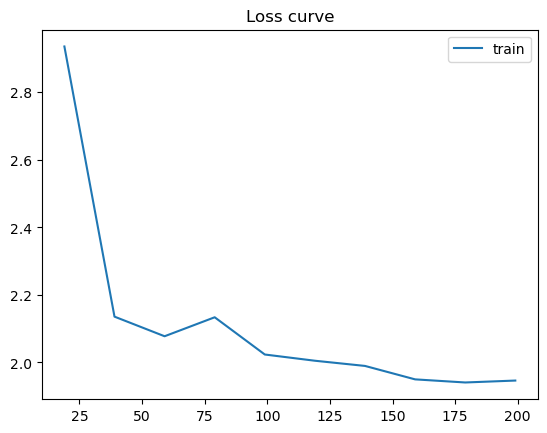

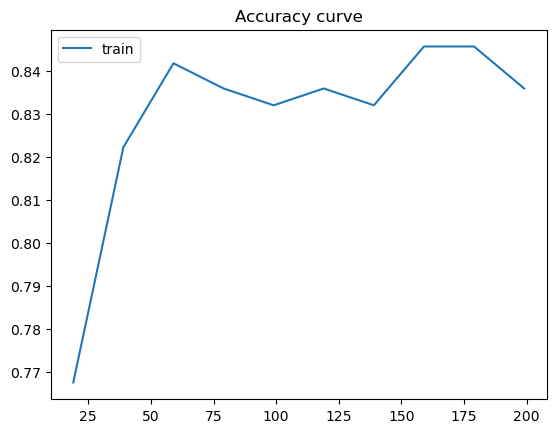

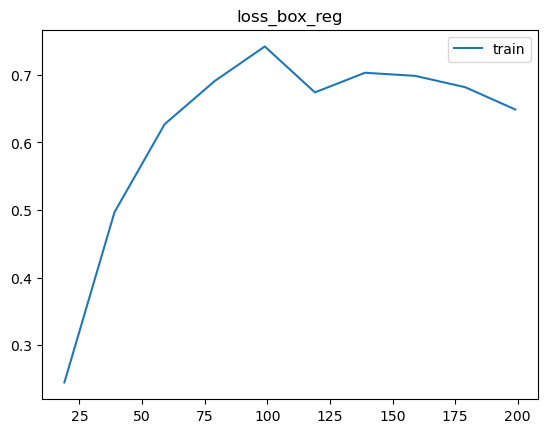

In [25]:
if is_train:
    # Load metrics
    metrics_df = pd.read_json(
        OUTPUT_DIR/"metrics.json", orient="records", lines=True
    )
    mdf = metrics_df.sort_values("iteration")
    print(mdf.head(10).T)

    # Plot loss
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["total_loss"].isna()]
    ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")

    if "validation_loss" in mdf.columns:
        mdf2 = mdf[~mdf["validation_loss"].isna()]
        ax.plot(mdf2["iteration"], mdf2["validation_loss"],
                c="C1", label="validation")

    ax.legend()
    ax.set_title("Loss curve")
    plt.show()

    # Plot Accuracy
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
    ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"],
            c="C0", label="train")

    ax.legend()
    ax.set_title("Accuracy curve")
    plt.show()

    # Plot Bounding Box regressor loss
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["loss_box_reg"].isna()]
    ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")

    ax.legend()
    ax.set_title("loss_box_reg")
    plt.show()

# 8 Evaluation

Can evaluate trained model on validation dataset to obtain different metric scores. 

In [26]:
if is_evaluate:
    print("### EVALUATING ON VALIDATION DATA ####")
    # trained model weights
    cfg.MODEL.WEIGHTS = str(MODEL_PATH)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold

    cfg.SOLVER.IMS_PER_BATCH = 64

    evaluator = COCOEvaluator(
        DATA_REGISTER_VALID, cfg, False, output_dir=cfg.OUTPUT_DIR, use_fast_impl=True
    )

    val_loader = build_detection_test_loader(cfg, DATA_REGISTER_VALID)

    results = inference_on_dataset(
        trainer.model, val_loader, evaluator=evaluator
    )

# 9 Inference

## 9.1 Setting Up Inference Model

In [27]:
inf_cfg = get_cfg()

config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

inf_cfg.merge_from_file(model_zoo.get_config_file(config_name))
inf_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
inf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
inf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
inf_cfg.MODEL.DEVICE = "cuda"

inf_cfg.DATALOADER.NUM_WORKERS = 2  # lower this if CUDA overflow occurs
inf_cfg.MODEL.WEIGHTS = str(MODEL_PATH)

In [28]:
BATCH = 8  # lower this if CUDA overflow occurs
test_loader = build_detection_test_loader(inf_cfg, DATA_REGISTER_TEST, batch_size=BATCH)

  0%|          | 0/13000 [00:00<?, ?it/s]

[07/19 13:51:47 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 0            |  text_box  | 0            |   image    | 0            |
|   table    | 0            |            |              |            |              |
|   total    | 0            |            |              |            |              |
[07/19 13:51:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/19 13:51:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/19 13:51:47 d2.data.common]: Serializing 13000 elements to byte tensors and concatenating them all ...
[07/19 13:51:47 d2.data.common]: Serialized dataset takes 2.07 MiB


How confident should the model be for you to accept the predicted mask?

In [29]:
ACCEPTANCE_THRESHOLD = 0.6  # for all categories

In [30]:
print(f"#### MODEL: {inf_cfg.MODEL.WEIGHTS} FOR INFERENCE ####")

#### MODEL: output/model_final.pth FOR INFERENCE ####


## 9.2 Sample Inference

In [31]:
predictor = DefaultPredictor(inf_cfg)

[07/19 13:51:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...


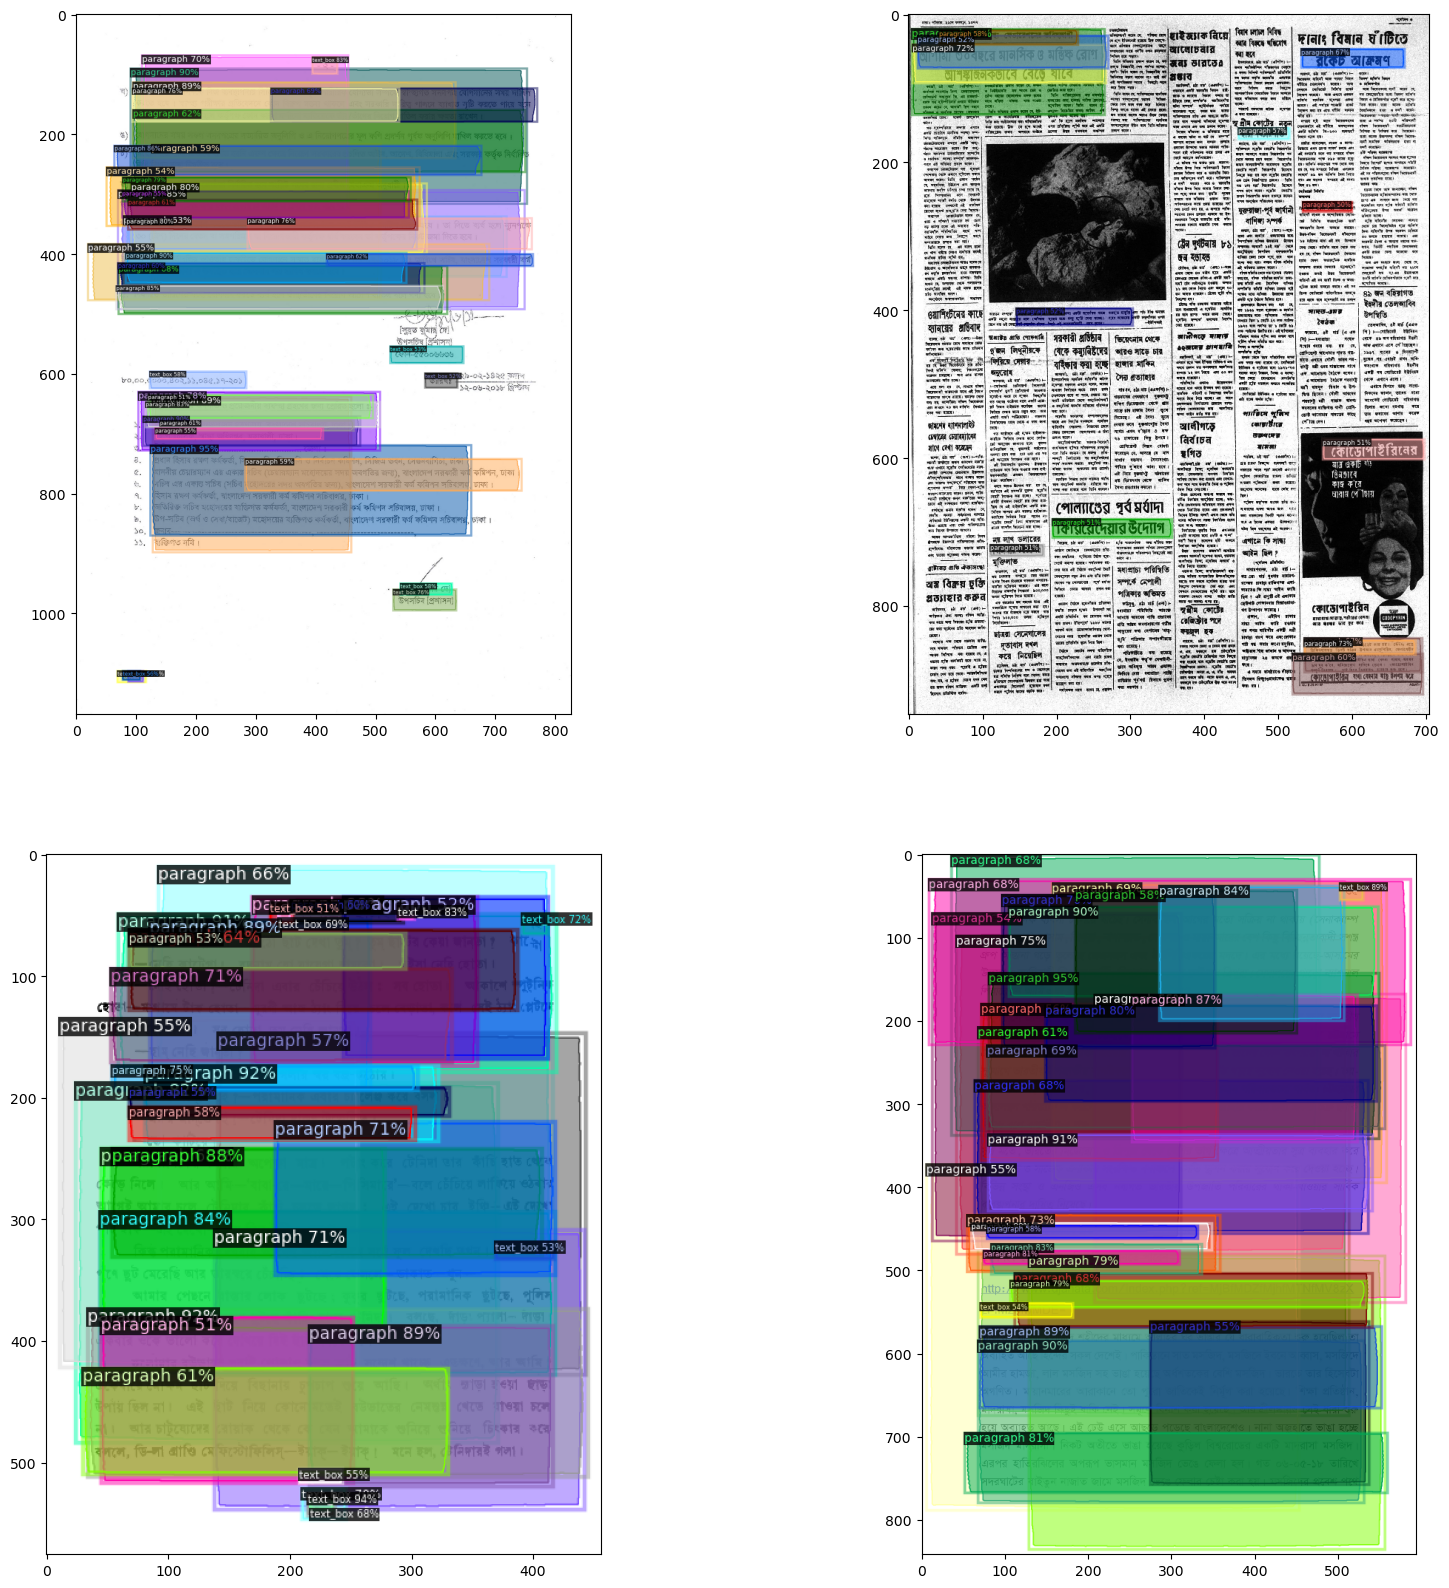

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
indices = [ax[0][0], ax[1][0], ax[0][1], ax[1][1]]

# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = np.random.choice(dataset_dicts_test, NUM_TEST_SAMPLES)

for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_test, scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu")
    )
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)

## 9.3 Test Data Inference and Submission

### 9.3.1 Building Inference Model

In [33]:
def rebuild_model():
    model = build_model(inf_cfg)
    _ = DetectionCheckpointer(model).load(inf_cfg.MODEL.WEIGHTS)
    return model

In [34]:
model = rebuild_model()

[07/19 13:52:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...


### 9.3.2 CUDA Problems

In [35]:
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

Occassionally CUDA memory overflow occurs. Trying to save as much VRAM as we can. 

In [36]:
vars_to_del = ["trainer", "predictor", "outputs"]

for v in vars_to_del:
    if v in globals():
        print(f"Deleting {v}")
        del globals()[v]
    elif v in locals():
        print(f"Deleting {v}")
        del locals()[v]

Deleting trainer
Deleting predictor
Deleting outputs


### 9.3.3 Inference Utils

In [37]:
def rle_encode(mask):
    pixels = mask.T.flatten()
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return ' '.join(str(x) for x in rle)

In [38]:
@retry_if_cuda_oom
def get_masks(prediction):
    # get masks for each category
    take = prediction.scores >= ACCEPTANCE_THRESHOLD
    pred_masks = (prediction.pred_masks[take] != 0)
    pred_classes = prediction.pred_classes[take]
  
    rles = []
    for cat in range(len(thing_classes)):
        pred_mask = pred_masks[pred_classes == cat]
        
        # pred_mask = retry_if_cuda_oom(torch.any)(pred_mask, dim=0)
        pred_mask = torch.any(pred_mask, dim=0)
        rles.append(rle_encode(pred_mask.short().to("cpu").numpy()))

    return rles

In [39]:
def run_inference(data):
    results = []
    with torch.no_grad():
        outputs = model(data)
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        for idx, output in enumerate(outputs):
            output = output["instances"]

            rles = get_masks(output)

            result = [
                f"{data[idx]['image_id']}_{cat},{rles[cat]}\n"
                for cat in range(len(thing_classes))
            ]

            results.extend(result)

        del outputs, output

    return results

### 9.3.4 Running Inference on Test Data and Creating Submission File
This is super slow. 

In [40]:
print("#### RUNNING INFERENCE ON TEST DATA ####")

#### RUNNING INFERENCE ON TEST DATA ####


In [41]:
torch.cuda.empty_cache()
gc.collect()

34570

In [42]:
if is_inference:
    model.eval()
    submission_file = open("submission.csv", "w")
    submission_file.write("Id,Predicted\n")

    results: list[str] = []
    
    for i, data in enumerate(tqdm(test_loader)):
        res = run_inference(data)
        results.extend(res)
        
        if i % (500 // BATCH) == 0:
            print(f"Inference on batch {i}/{len(test_loader)} done")
            submission_file.writelines(results)
            results = []

    submission_file.writelines(results)
    submission_file.close()

  0%|          | 0/1625 [00:00<?, ?it/s]

Inference on batch 0/1625 done
Inference on batch 62/1625 done
Inference on batch 124/1625 done
Inference on batch 186/1625 done
Inference on batch 248/1625 done
Inference on batch 310/1625 done
Inference on batch 372/1625 done
Inference on batch 434/1625 done
Inference on batch 496/1625 done
Inference on batch 558/1625 done
Inference on batch 620/1625 done
Inference on batch 682/1625 done
Inference on batch 744/1625 done
Inference on batch 806/1625 done
Inference on batch 868/1625 done
Inference on batch 930/1625 done
Inference on batch 992/1625 done
Inference on batch 1054/1625 done
Inference on batch 1116/1625 done
Inference on batch 1178/1625 done
Inference on batch 1240/1625 done
Inference on batch 1302/1625 done
Inference on batch 1364/1625 done
Inference on batch 1426/1625 done
Inference on batch 1488/1625 done
Inference on batch 1550/1625 done
Inference on batch 1612/1625 done


In [43]:
if Path("submission.csv").exists:
    display(FileLink("submission.csv"))

/kaggle/working/submission.csv

In [44]:
!rm -r detectron2/